# Intravoxel incoherent motion (IVIM) imaging

In [1]:
import matplotlib.pyplot as plt
from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim

In [2]:
img, gtab = read_ivim()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/lucas/.dipy/ivim 


In [3]:
gtab.big_delta

In [4]:
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)
z = 33
x1, x2 = 90, 155
y1, y2 = 90, 170
data_slice = data[x1:x2, y1:y2, z, :]

data.shape (256, 256, 54, 21)


In [5]:
ivimmodel = IvimModel(gtab)
ivim_fit_dipy = ivimmodel.fit(data_slice)

/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:404: UserWarning: x0 obtained from linear fitting is not feasibile as initial guess for leastsq while estimating f and D_star. Using parameters from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:498: UserWarning: x0 is unfeasible for leastsq fitting. Returning x0 values from the linear fit.
  warnings.warn(warningMsg, UserWarning)
/home/lucas/anaconda2/lib/python2.7/site-packages/dipy-0.14.0-py2.7-linux-x86_64.egg/dipy/reconst/ivim.py:293: UserWarning: Bounds are violated for leastsq fitting. Returning parameters from linear fit
  warnings.warn(warningMsg, UserWarning)


In [6]:
from dmipy.signal_models import gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.core.acquisition_scheme import gtab_dipy2dmipy, acquisition_scheme_from_bvalues

In [7]:
scheme_ivim = gtab_dipy2dmipy(gtab, b0_threshold=1e6, min_b_shell_distance=1e6)
scheme_ivim.print_acquisition_info

Acquisition scheme summary

total number of measurements: 21
number of b0 measurements: 1
number of DWI shells: 20

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |1         |0               |N/A                      |N/A        |N/A       |N/A  
1           |1         |10              |N/A                      |N/A        |N/A       |N/A  
2           |1         |20              |N/A                      |N/A        |N/A       |N/A  
3           |1         |30              |N/A                      |N/A        |N/A       |N/A  
4           |1         |40              |N/A                      |N/A        |N/A       |N/A  
5           |1         |60              |N/A                      |N/A        |N/A       |N/A  
6           |1         |80              |N/A                      |N/A        |N/A       |N/A  
7           |1         |100             |N/A                      |N/A        |N/A       |N/A  
8           |1     

/home/lucas/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/acquisition_scheme.py:852: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


In [8]:
from dmipy.custom_optimizers import intra_voxel_incoherent_motion

In [17]:
ivim_fit_dmipy = intra_voxel_incoherent_motion.intra_voxel_incoherent_motion(
    scheme_ivim, data_slice, Ns=10)

Starting step 1 of IVIM fitting algorithm.
Cannot estimate signal grid with voxel-dependent x0_vector.
Starting step 2 of IVIM fitting algorithm.
Cannot estimate signal grid with voxel-dependent x0_vector.
IVIM optimization of 5200 voxels complete in 129.643 seconds


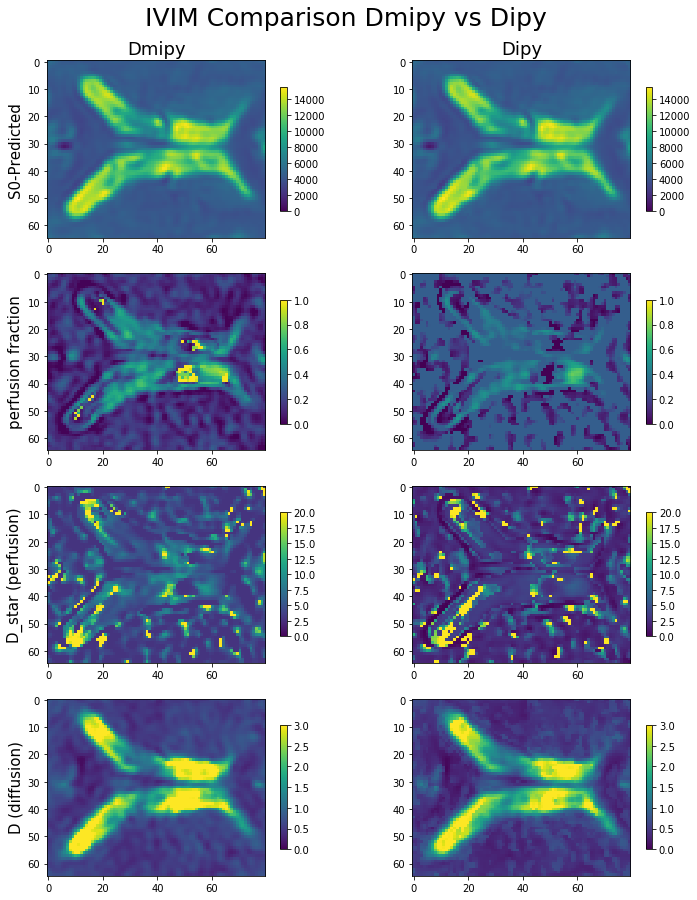

In [20]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=[12, 15])
fig.suptitle('IVIM Comparison Dmipy vs Dipy', fontsize=25, y=0.93)
axs = axs.ravel()
axs[0].set_title('Dmipy', fontsize=18)
axs[1].set_title('Dipy', fontsize=18)
axs[0].set_ylabel('S0-Predicted', fontsize=15)
axs[2].set_ylabel('perfusion fraction', fontsize=15)
axs[4].set_ylabel('D_star (perfusion)', fontsize=15)
axs[6].set_ylabel('D (diffusion)', fontsize=15)

args = {'vmin': 0., 'interpolation': 'nearest'}
im = axs[0].imshow(ivim_fit_dmipy.S0, **args)
fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(ivim_fit_dipy.S0_predicted, **args)
fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow(ivim_fit_dmipy.fitted_parameters['partial_volume_1'], vmax=1., **args)
fig.colorbar(im, ax=axs[2], shrink=0.7)
im = axs[3].imshow(ivim_fit_dipy.perfusion_fraction, vmax=1., **args)
fig.colorbar(im, ax=axs[3], shrink=0.7)
im = axs[4].imshow(ivim_fit_dmipy.fitted_parameters['G1Ball_2_lambda_iso'] * 1e9, vmax=20, **args)
fig.colorbar(im, ax=axs[4], shrink=0.7)
im = axs[5].imshow(ivim_fit_dipy.D_star * 1e3, vmax=20, **args)
fig.colorbar(im, ax=axs[5], shrink=0.7)
im = axs[6].imshow(ivim_fit_dmipy.fitted_parameters['G1Ball_1_lambda_iso'] * 1e9, vmax=3, **args)
fig.colorbar(im, ax=axs[6], shrink=0.7)
im = axs[7].imshow(ivim_fit_dipy.D * 1e3, vmax=3, **args)
fig.colorbar(im, ax=axs[7], shrink=0.7)

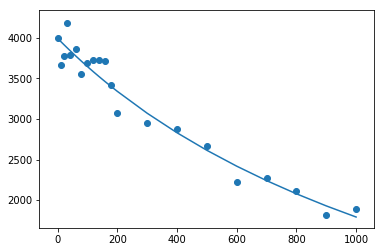

In [16]:
plt.plot(gtab.bvals, ivim_fit_dmipy.predict()[10, 10])
plt.scatter(gtab.bvals, data_slice[10, 10])